# <center> Customer Segmentation - Hybrid Modelling

<b>The objective is to combine unsupervised and supervised learning to create a hybrid model to categorize customers

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Import module for data visualization
from plotnine import *
import plotnine
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

## Objective

To divide the dataset into k clusters and apply multi-class classification on each cluster

## Reading Dataset

In [2]:
df = pd.read_csv("./data.csv")

In [3]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


## Data Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


#### ID

In [5]:
# drop ID column as its insignificant to our model
df.drop('ID', axis = 1, inplace = True)

#### Gender

In [6]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

#### Ever_Married

In [7]:
df.Ever_Married.unique()

array(['No', 'Yes', nan], dtype=object)

In [8]:
# Filling nan values with "No"
df.Ever_Married.fillna('No', inplace = True)

#### Age

In [9]:
df.Age.unique()

array([22, 38, 67, 40, 56, 32, 33, 61, 55, 26, 19, 70, 58, 41, 31, 79, 49,
       18, 36, 35, 45, 42, 83, 27, 28, 47, 29, 57, 76, 25, 72, 48, 74, 59,
       39, 51, 30, 63, 52, 60, 68, 86, 50, 43, 80, 37, 46, 69, 78, 71, 82,
       23, 20, 85, 21, 53, 62, 75, 65, 89, 66, 73, 77, 87, 84, 81, 88])

#### Graduated

In [10]:
df.Graduated.unique()

array(['No', 'Yes', nan], dtype=object)

In [11]:
# Filling nan values with "No"
df.Graduated.fillna("No", inplace = True)

#### Profession

In [12]:
df.Profession.unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [13]:
# Assuming nan values are individuals without a job, we fill nan values with 'Homemaker'
df.Profession.fillna('Homemaker', inplace = True)

#### Work Experience

In [14]:
df.Work_Experience.unique()

array([ 1., nan,  0.,  4.,  9., 12.,  3., 13.,  5.,  8., 14.,  7.,  2.,
        6., 10., 11.])

In [15]:
# fill nan values with 0.0
df.Work_Experience.fillna(0.0, inplace = True)

#### Spending_Score

In [16]:
df.Spending_Score.unique()

array(['Low', 'Average', 'High'], dtype=object)

#### Family_Size

In [17]:
df.Family_Size.unique()

array([ 4.,  3.,  1.,  2.,  6., nan,  5.,  8.,  7.,  9.])

In [18]:
df.Family_Size.isna().sum()

335

In [19]:
# fill na values with 1.0 assuming nan = single sized family
df.Family_Size.fillna(1.0, inplace = True)
df.Family_Size.fillna(1.0, inplace = True)

#### Var_1


In [20]:
df.Var_1.unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', nan, 'Cat_5'],
      dtype=object)

In [21]:
df.Var_1.isna().sum()

76

In [22]:
# drop rows with na values in Var_1
df = df[df['Var_1'].notna()]

In [23]:
# convert this column to numeric
df['Var_1'] = df.Var_1.str.extract(r'(\d)').astype('float64')

In [24]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,4.0,D
1,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,4.0,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,6.0,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,6.0,B
4,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,6.0,A


## Increasing size of dataset by random sampling 

In [25]:
df.size

79920

In [26]:
sample = df.sample(frac=0.30)
df = df.append(sample)

In [27]:
df.size

103900

## Feature Scaling - Normalizing numeric columns

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Extract numerical column positions
numeric_cols = ['Age', 'Work_Experience', 'Family_Size', 'Var_1']
scaler = MinMaxScaler().fit(df[numeric_cols])

In [29]:
df[numeric_cols] = scaler.transform(df[numeric_cols])

In [30]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,0.056338,No,Healthcare,0.071429,Low,0.375,0.500000,D
1,Female,Yes,0.281690,Yes,Engineer,0.000000,Average,0.250,0.500000,A
2,Female,Yes,0.690141,Yes,Engineer,0.071429,Low,0.000,0.833333,B
3,Male,Yes,0.690141,Yes,Lawyer,0.000000,High,0.125,0.833333,B
4,Female,Yes,0.309859,Yes,Entertainment,0.000000,High,0.625,0.833333,A


## K-prototype clustering

The K-Prototype clustering algorithm in kmodes module needs categorical variables or columns position in the data. 

In [31]:
# import module for k-prototype
from kmodes.kprototypes import KPrototypes

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10390 entries, 0 to 5977
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10390 non-null  object 
 1   Ever_Married     10390 non-null  object 
 2   Age              10390 non-null  float64
 3   Graduated        10390 non-null  object 
 4   Profession       10390 non-null  object 
 5   Work_Experience  10390 non-null  float64
 6   Spending_Score   10390 non-null  object 
 7   Family_Size      10390 non-null  float64
 8   Var_1            10390 non-null  float64
 9   Segmentation     10390 non-null  object 
dtypes: float64(4), object(6)
memory usage: 892.9+ KB


In [33]:
category_columns_position = [df.columns.get_loc(col) for col in list(df.select_dtypes('O').columns)]

In [34]:
category_columns_position

[0, 1, 3, 4, 6, 9]

In [35]:
# Convert dataframe to matrix
df_matrix = df.to_numpy()
df_matrix

array([['Male', 'No', 0.05633802816901412, ..., 0.375, 0.5, 'D'],
       ['Female', 'Yes', 0.2816901408450705, ..., 0.25, 0.5, 'A'],
       ['Female', 'Yes', 0.6901408450704226, ..., 0.0,
        0.8333333333333334, 'B'],
       ...,
       ['Male', 'Yes', 0.3380281690140845, ..., 0.125,
        0.8333333333333334, 'C'],
       ['Male', 'No', 0.09859154929577468, ..., 0.75, 0.8333333333333334,
        'D'],
       ['Male', 'Yes', 0.5211267605633803, ..., 0.125,
        0.8333333333333334, 'A']], dtype=object)

In [36]:
df.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

### Elbow method for finding optimal no. of clusters

In [37]:
category_columns_position

[0, 1, 3, 4, 6, 9]

In [38]:
cost = []
for cluster in range(1,10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(df_matrix, categorical = category_columns_position)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


In [39]:
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})

In [40]:
df_cost

,Cluster,Cost
0,1,5719.366755
1,2,4565.557385
2,3,4056.569793
3,4,3747.618776
4,5,3503.132837
5,6,3332.062187
6,7,3233.367810
7,8,3103.224866
8,9,2981.160128


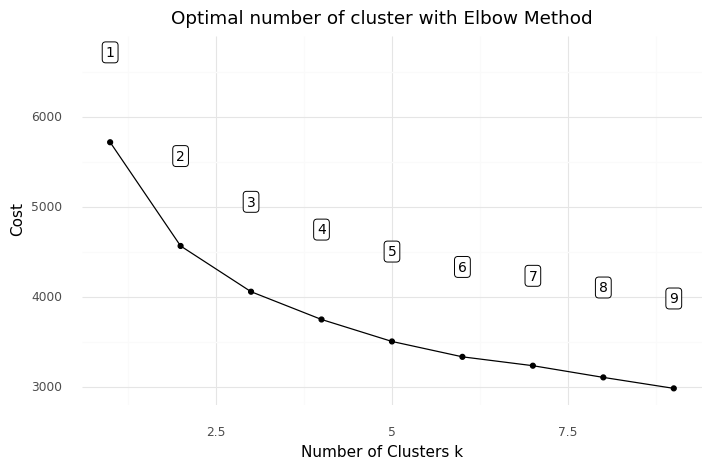

<ggplot: (674341150)>

In [41]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

<b> Based on the above plot, lets assume k = 3

In [42]:
# Fitting the clusters
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(df_matrix, categorical = category_columns_position)

array([1, 2, 2, ..., 2, 1, 2], dtype=uint16)

In [43]:
# Add clusters 
df['Cluster'] = kprototype.labels_

In [44]:
df.tail()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Cluster
1414,Male,Yes,0.464789,Yes,Engineer,0.000000,Low,0.125,0.500000,A,2
6985,Male,No,0.436620,No,Entertainment,0.071429,Low,0.250,0.333333,D,1
7423,Male,Yes,0.338028,Yes,Artist,0.500000,Average,0.125,0.833333,C,2
4963,Male,No,0.098592,No,Entertainment,0.142857,Low,0.750,0.833333,D,1
5977,Male,Yes,0.521127,Yes,Entertainment,0.071429,Low,0.125,0.833333,A,2


In [45]:
df['Cluster'].value_counts()

2    4535
1    2937
0    2918
Name: Cluster, dtype: int64

In [46]:
df1 = df[df.Cluster == 0]
df2 = df[df.Cluster == 1]
df3 = df[df.Cluster == 2]

In [47]:
df1.drop(['Cluster'], axis = 1, inplace = True)
df2.drop(['Cluster'], axis = 1, inplace = True)
df3.drop(['Cluster'], axis = 1, inplace = True)

/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/664932745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/664932745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/664932745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
df1['Segmentation'].value_counts()

A    1366
B     709
D     533
C     310
Name: Segmentation, dtype: int64

In [49]:
df2['Segmentation'].value_counts()

D    2025
A     334
B     293
C     285
Name: Segmentation, dtype: int64

In [50]:
df3['Segmentation'].value_counts()

C    1942
B    1390
A     844
D     359
Name: Segmentation, dtype: int64

## Multi-Class Classification on each cluster

<b> Now, we have 3 subsets of the data from clustering. We perform classification individually on each subset of data and compute the mean accuracy

From the above distributions, we can see that the classes are imbalanced, and this will cause the model to be biased towards a particular class. Therefore, we need to oversample to address the class imbalance problem.

## Decision Tree Classifier

#### Label Encoding

In [51]:
category_columns_position

[0, 1, 3, 4, 6, 9]

In [52]:
df1.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
10,Female,No,0.112676,Yes,Engineer,0.071429,Low,0.250,0.833333,A
14,Female,Yes,0.563380,No,Doctor,0.000000,Low,0.000,0.333333,B
20,Male,Yes,0.436620,Yes,Homemaker,0.857143,Low,0.000,0.333333,A
22,Male,Yes,0.211268,Yes,Artist,0.928571,Low,0.125,0.333333,A
23,Female,No,0.253521,Yes,Artist,0.357143,Low,0.125,0.833333,B


In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1.Gender = le.fit_transform(df1['Gender'])
df1.Ever_Married = le.fit_transform(df1['Ever_Married'])
df1.Graduated = le.fit_transform(df1['Graduated'])
df1.Profession = le.fit_transform(df1['Profession'])
df1.Spending_Score = le.fit_transform(df1['Spending_Score'])
df1.Segmentation = le.fit_transform(df1['Segmentation'])

df2.Gender = le.fit_transform(df2['Gender'])
df2.Ever_Married = le.fit_transform(df2['Ever_Married'])
df2.Graduated = le.fit_transform(df2['Graduated'])
df2.Profession = le.fit_transform(df2['Profession'])
df2.Spending_Score = le.fit_transform(df2['Spending_Score'])
df2.Segmentation = le.fit_transform(df2['Segmentation'])

df3.Gender = le.fit_transform(df3['Gender'])
df3.Ever_Married = le.fit_transform(df3['Ever_Married'])
df3.Graduated = le.fit_transform(df3['Graduated'])
df3.Profession = le.fit_transform(df3['Profession'])
df3.Spending_Score = le.fit_transform(df3['Spending_Score'])
df3.Segmentation = le.fit_transform(df3['Segmentation'])

/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/1268981441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/1268981441.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/c9/s8djz0q939q5zk6br0gymtm80000gn/T/ipykernel_89714/1268981441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### Cluster 1

### Addressing Class Imbalance Problem

In [54]:
df1['Segmentation'].value_counts()

0    1366
1     709
3     533
2     310
Name: Segmentation, dtype: int64

In [55]:
from imblearn.over_sampling import SMOTE

In [56]:
# X is all columns except the segmentation, y is segmentation
X = df1.drop(['Segmentation'], axis = 1)
y = df1['Segmentation']

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [57]:
y.value_counts()

0    1366
1    1366
2    1366
3    1366
Name: Segmentation, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Hyperparameter Tuning

In [59]:
from sklearn.model_selection import GridSearchCV

def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 20)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [60]:
best = dtree_grid_search(X_train, y_train, 10)
print(best)

{'criterion': 'gini', 'max_depth': 15}


In [61]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion = best['criterion'], 
                               max_depth = best['max_depth'], 
                               random_state = 1).fit(X_train, y_train)

In [62]:
predictions = dtree.predict(X_test)

In [63]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       462
           1       0.64      0.65      0.64       431
           2       0.73      0.70      0.72       464
           3       0.74      0.75      0.74       447

    accuracy                           0.68      1804
   macro avg       0.68      0.68      0.68      1804
weighted avg       0.68      0.68      0.68      1804



In [64]:
acc1 = accuracy_score(y_test, predictions)
print(acc1)

0.6829268292682927


### Cluster 2

In [65]:
# X is all columns except the segmentation, y is segmentation
X = df2.drop(['Segmentation'], axis = 1)
y = df2['Segmentation']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
best = dtree_grid_search(X_train, y_train, 10)
print(best)

{'criterion': 'entropy', 'max_depth': 19}


In [68]:
dtree = DecisionTreeClassifier(criterion = best['criterion'], 
                               max_depth = best['max_depth'], 
                               random_state = 1).fit(X_train, y_train)

In [69]:
predictions = dtree.predict(X_test)

In [70]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       654
           1       0.82      0.81      0.81       717
           2       0.78      0.81      0.79       628
           3       0.82      0.79      0.81       674

    accuracy                           0.81      2673
   macro avg       0.81      0.81      0.81      2673
weighted avg       0.81      0.81      0.81      2673



In [71]:
acc2 = accuracy_score(y_test, predictions)
print(acc2)

0.8114478114478114


### Cluster 3

In [72]:
# X is all columns except the segmentation, y is segmentation
X = df3.drop(['Segmentation'], axis = 1)
y = df3['Segmentation']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [74]:
best = dtree_grid_search(X_train, y_train, 10)

In [75]:
dtree = DecisionTreeClassifier(criterion = best['criterion'], 
                               max_depth = best['max_depth'], 
                               random_state = 1).fit(X_train, y_train)

In [76]:
predictions = dtree.predict(X_test)

In [77]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       633
           1       0.57      0.55      0.56       647
           2       0.63      0.67      0.65       647
           3       0.80      0.76      0.78       637

    accuracy                           0.65      2564
   macro avg       0.66      0.65      0.65      2564
weighted avg       0.66      0.65      0.65      2564



In [78]:
acc3 = accuracy_score(y_test, predictions)
print(acc3)

0.6540561622464899


## Computing Final Accuracy

We take the mean accuracy from all the 3 clusters to compute the final accuracy

In [79]:
print(f'Final accuracy = {round((acc1+acc2+acc3)*100/3, 2)} %')

Final accuracy = 71.61 %
